In [1]:
from alns import ALNS, State

import itertools

import numpy.random as rnd

import networkx as nx

import tsplib95
import tsplib95.distances as distances

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
SEED = 9876

# The travelling salesman problem

The travelling salesman problem (TSP) is a classic problem in operations research. It asks how to construct the minimum distance tour between a number of cities, such that each city is visited once and the tour concludes at the starting city (that is, it forms a cycle). It is perhaps the best-known problem in the class of [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) problems.

### Data
There are a considerable number of test data sets available for the TSP, varying in size from a hundred or so locations to many hundreds of thousands. For the sake of exposition, we shall use one of the smaller data sets: the data from the XQF131 VLSI instance, made available [here](http://www.math.uwaterloo.ca/tsp/vlsi/index.html#XQF131). It consists of 'only' 131 cities, with an optimal tour length of 564.

In [4]:
data = tsplib95.load_problem('examples/xqf131.tsp')

solution = tsplib95.load_solution('examples/xqf131.opt.tour')
optimal = data.trace_tours(solution)[0]

print('Total optimal tour length is {0}.'.format(optimal))

Total optimal tour length is 564.


In [5]:
def draw_graph(graph, only_nodes=False):
    """
    Helper method for drawing TSP (tour) graphs.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    func = nx.draw_networkx

    if only_nodes:
        func = nx.draw_networkx_nodes

    func(graph, data.node_coords, node_size=25, with_labels=False, ax=ax)

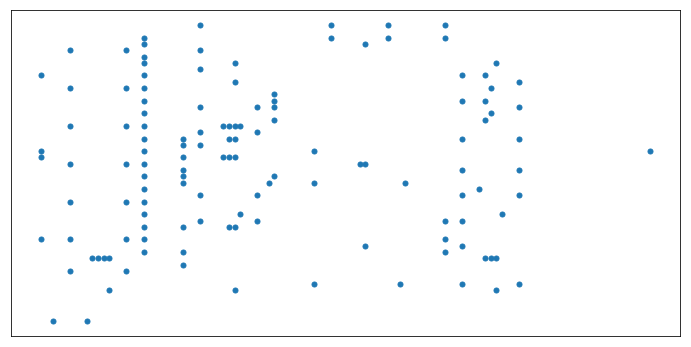

In [6]:
draw_graph(data.get_graph(), True)

# Operators and solution state

To use the ALNS meta-heuristic, we need to have destroy and repair operators that work on a proposed solution, and a way to describe such a solution in the first place. The ALNS package exposes the class ``State`` to describe a solution, with an ``objective()`` member that computes this solution's objective value. Using it, we may compute a simple initial solution, and then apply the ALNS algorithm.

## Solution state

In [7]:
class TspState(State):
    """
    Solution class for the TSP problem. It has two data members, nodes, and edges.
    nodes is a list of node tuples: (id, coords). The edges data member, then, is
    a mapping from each node to their only outgoing node.
    """

    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

    def copy(self):
        """
        Helper method to ensure each solution state is immutable.
        """
        return TspState(self.nodes.copy(),
                        self.edges.copy())

    def objective(self):
        """
        The objective function is simply the sum of all individual edge lengths,
        using the rounded Euclidean norm.
        """
        return sum(distances.euclidean(node[1], self.edges[node][1])
                   for node in self.nodes)
    
    def to_graph(self):
        """
        NetworkX helper method.
        """
        graph = nx.Graph()

        for node, coord in self.nodes:
            graph.add_node(node, pos=coord)

        for node_from, node_to in self.edges.items():
            graph.add_edge(node_from[0], node_to[0])

        return graph

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider three destroy operators: **worst removal**, **path removal** and **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [8]:
degree_of_destruction = 0.25

def edges_to_remove(state):
    return int(len(state.edges) * degree_of_destruction)

In [9]:
def worst_removal(current, random_state):
    """
    Worst removal iteratively removes the 'worst' edges, that is,
    those edges that have the largest distance.
    """
    destroyed = current.copy()

    worst_edges = sorted(destroyed.nodes,
                         key=lambda node: distances.euclidean(node[1],
                                                              destroyed.edges[node][1]))

    for idx in range(edges_to_remove(current)):
        del destroyed.edges[worst_edges[-idx -1]]

    return destroyed

In [10]:
def path_removal(current, random_state):
    """
    Removes an entire consecutive subpath, that is, a series of
    contiguous edges.
    """
    destroyed = current.copy()
    
    node_idx = random_state.choice(len(destroyed.nodes))
    node = destroyed.nodes[node_idx]
    
    for _ in range(edges_to_remove(current)):
        node = destroyed.edges.pop(node)

    return destroyed

In [11]:
def random_removal(current, random_state):
    """
    Random removal iteratively removes random edges.
    """
    destroyed = current.copy()
    
    for idx in random_state.choice(len(destroyed.nodes),
                                   edges_to_remove(current),
                                   replace=False):
        del destroyed.edges[destroyed.nodes[idx]]

    return destroyed

## Repair operators

We implement a simple, **greedy repair** strategy. It determines a set of nodes that are currently not visited, and then links these up to the tour such that it forms one cycle.

In [12]:
def would_form_subcycle(from_node, to_node, state):
    """
    Ensures the proposed solution would not result in a cycle smaller
    than the entire set of nodes. Notice the offsets: we do not count
    the current node under consideration, as it cannot yet be part of
    a cycle.
    """
    for step in range(1, len(state.nodes)):
        if to_node not in state.edges:
            return False

        to_node = state.edges[to_node]
        
        if from_node == to_node and step != len(state.nodes) - 1:
            return True

    return False

In [13]:
def greedy_repair(current, random_state):
    """
    Greedily repairs a tour, stitching up nodes that are not departed
    with those not visited.
    """
    visited = set(current.edges.values())
  
    # This kind of randomness ensures we do not cycle between the same
    # destroy and repair steps every time.
    shuffled_idcs = random_state.permutation(len(current.nodes))
    nodes = [current.nodes[idx] for idx in shuffled_idcs]

    while len(current.edges) != len(current.nodes):
        node = next(node for node in nodes 
                    if node not in current.edges)

        # Computes all nodes that have not currently been visited,
        # that is, those that this node might visit. This should
        # not result in a subcycle, as that would violate the TSP
        # constraints.
        unvisited = {other for other in current.nodes
                     if other != node
                     if other not in visited
                     if not would_form_subcycle(node, other, current)}

        # Closest visitable node.
        nearest = min(unvisited,
                      key=lambda other: distances.euclidean(node[1], other[1]))

        current.edges[node] = nearest
        visited.add(nearest)

    return current

## Initial solution

In [14]:
random_state = rnd.RandomState(SEED)
state = TspState(list(data.node_coords.items()), {})

initial_solution = greedy_repair(state, random_state)

print("Initial solution objective is {0}.".format(initial_solution.objective()))

Initial solution objective is 851.


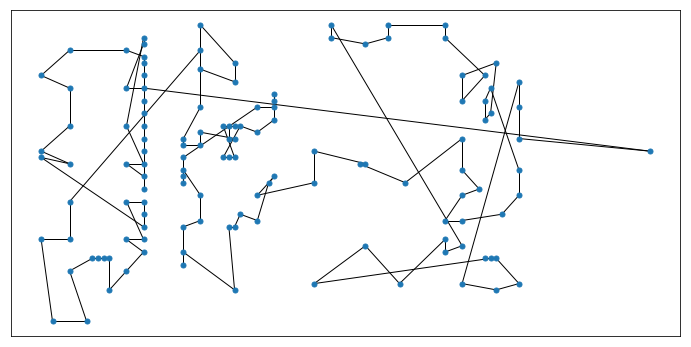

In [15]:
draw_graph(initial_solution.to_graph())

# Heuristic solution

In [16]:
alns = ALNS(random_state)

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(path_removal)
alns.add_destroy_operator(worst_removal)

alns.add_repair_operator(greedy_repair)

In [17]:
result = alns.iterate(initial_solution, [3, 2, 1, 0.5], 0.8, 5000)
solution = result.best_state

objective = solution.objective()

In [18]:
print('Best heuristic objective is {0}.'.format(objective))
print('This is {0:.1f}% worse than the optimal solution, which is {1}.'
      .format(100 * (objective - optimal) / optimal, optimal))

Best heuristic objective is 619.
This is 9.8% worse than the optimal solution, which is 564.


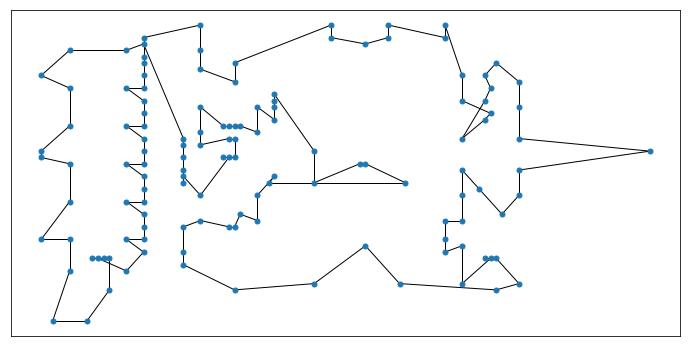

In [19]:
draw_graph(solution.to_graph())

## Post-processing

It is not difficult to see the above solution can easily be improved upon: there are plenty of inefficiencies in small subpaths near both the center and the various corners of the tour. We will partially remedy this with a single pass over all nodes, optimally choosing a subpath of length ``k`` starting at each of these nodes. Since such a process is computationally demanding, we select ``k = 6``.

In [20]:
k = 6

In [21]:
def fix_bounds(permutation, start_node, end_node):
    """
    Fixes the given permutation to the start and end nodes, such that
    it connects up to the remainder of the solution.
    """
    return (start_node,) + permutation + (end_node,)

In [22]:
def optimal_subpath(nodes, start_node, end_node):
    """
    Computes the minimum cost subpath from the given nodes, where the 
    subpath is fixed at start_node and end_node.
    """
    def cost(subpath):
        path = fix_bounds(subpath, start_node, end_node)
        
        return sum(distances.euclidean(path[idx][1], path[idx + 1][1])
                   for idx in range(len(path) - 1))

    subpath = min(itertools.permutations(nodes, k), key=cost)

    return fix_bounds(subpath, start_node, end_node)

In [23]:
def post_process(state):
    """
    For each node in the passed-in state, this post processing step 
    computes the optimal subpath consisting of the next k nodes. This
    results in a run-time complexity of about O(n * k!), where n is
    the number of nodes.
    """
    state = state.copy()

    for start_node in state.nodes:
        nodes = []
        node = start_node

        # Determine the next k nodes that make up the subpath starting
        # at this start_node.
        for _ in range(k):
            node = state.edges[node]
            nodes.append(node)
        
        end_node = state.edges[node]

        optimal = optimal_subpath(nodes, start_node, end_node)
        
        # Replace the existing path with the optimal subpath.
        for first, second in zip(optimal, optimal[1:]):
            state.edges[first] = second

    return state

In [24]:
new_solution = post_process(solution)

new_objective = new_solution.objective()

print("New heuristic objective is {0}.".format(new_objective))
print('This is {0:.1f}% worse than the optimal solution, which is {1}.'
      .format(100 * (new_objective - optimal) / optimal, optimal))

New heuristic objective is 590.
This is 4.6% worse than the optimal solution, which is 564.


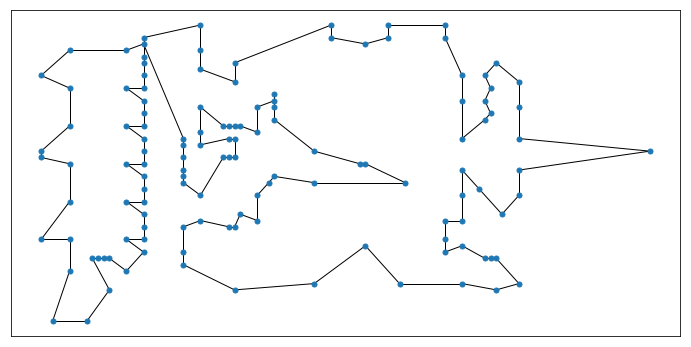

In [25]:
draw_graph(new_solution.to_graph())

# Conclusions

In the code above we implemented a very simple heuristic for the TSP, using the ALNS meta-heuristic framework. We did not tinker too much with the various hyperparameters available on the ALNS implementation, but even for these relatively basic heuristic methods and workflow we find a very good result - just 4.6% worse than the optimal tour.

This notebook showcases how the ALNS library may be put to use to construct powerful, efficient heuristic pipelines from simple, locally greedy operators.